In [13]:
from dataclasses import dataclass, asdict
from functools import cache
from functools import cached_property
import numpy as np
import numpy.typing as npt
import pandas as pd
import awkward as ak
from matplotlib.patches import Polygon
from  hist import intervals


@cache
def get_segment(ring: int, station: int, sector: int, subsector: int) -> int:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L361-L368
    """
    nsub = 3 if ring == 1 and station > 1 else 6
    return subsector + nsub * (sector - 1)


@cache
def get_roll_name(region: int, ring: int, station: int, sector: int, layer: int,
             subsector: int, roll: int
) -> str:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L11-L87
    """
    if region == 0:
        name = f'W{ring:+d}_RB{station}'

        if station <= 2:
            name += 'in' if layer == 1 else 'out'
        else:
            if sector == 4 and station == 4:
                name += ['--', '-', '+', '++'][subsector - 1]
            elif (station == 3) or (station == 4 and sector not in (4, 9, 11)):
                name += '-' if subsector == 1 else '+'
        name += f'_S{sector:0>2d}_'
        name += ['Backward', 'Middle', 'Forward'][roll - 1]
    else:
        segment = get_segment(ring, station, sector, subsector)
        name = f'RE{station * region:+d}_R{ring}_CH{segment:0>2d}_'
        name += ['A', 'B', 'C', 'D', 'E'][roll - 1]
    return name


@cache
def get_detector_unit(region: int, station: int, layer: int) -> str:
    """
    adapted from https://gitlab.cern.ch/seyang/RPCDPGAnalysis/-/blob/3d71b88e/SegmentAndTrackOnRPC/python/RPCGeom.py#L113-114
    """
    if region == 0:
        detector_unit = f'RB{station:d}'
        if station <= 2:
            detector_unit += 'in' if layer == 1 else 'out'
    else:
        detector_unit = f'RE{region * station:+d}'
    return detector_unit


@dataclass(frozen=True, unsafe_hash=True)
class RPCDetId:
    region: int
    ring: int
    station: int
    sector: int
    layer: int
    subsector: int
    roll: int

    @classmethod
    def from_obj(cls, obj):
        return cls(region=obj.region, ring=obj.ring, station=obj.station,
                   sector=obj.sector, layer=obj.layer, subsector=obj.subsector,
                   roll=obj.roll)

    @property
    def segment(self):
        return get_segment(ring=self.ring, station=self.station,
                           sector=self.sector, subsector=self.subsector)

    @property
    def name(self):
        kwargs = asdict(self)
        return get_roll_name(**kwargs)

    @property
    def detector_unit(self):
        return get_detector_unit(region=self.region, station=self.station,
                                 layer=self.layer)

    @property
    def barrel(self):
        return self.region == 0


@dataclass
class RPCRoll:
    id: RPCDetId
    x: npt.NDArray[np.float64]
    y: npt.NDArray[np.float64]
    z: npt.NDArray[np.float64]

    @classmethod
    def from_row(cls, row: pd.Series):
        x = row[[f'x{idx}' for idx in range(1, 5)]].to_numpy(np.float64)
        y = row[[f'y{idx}' for idx in range(1, 5)]].to_numpy(np.float64)
        z = row[[f'z{idx}' for idx in range(1, 5)]].to_numpy(np.float64)
        det_id = RPCDetId.from_obj(row)
        return cls(det_id, x, y, z)

    @cached_property
    def phi(self) -> npt.NDArray[np.float64]:
        phi = np.arctan2(self.y, self.x)
        phi[phi < 0] += 2 * np.pi
        if abs(phi[0] - phi[2]) > np.pi:
            phi[phi > np.pi] -= 2 * np.pi
        return phi

    @property
    def polygon(self) -> Polygon:
        # if barrel
        if self.id.barrel:
            xy = np.stack([self.z, self.phi], axis=1)
        else:
            xy = np.stack([self.x, self.y], axis=1)
        return Polygon(xy, closed=True)

    @property
    def polygon_xlabel(self) -> str:
        if self.id.barrel:
            xlabel = r'$z$ [cm]'
        else:
            xlabel = r'$x$ [cm]'
        return xlabel

    @property
    def polygon_ylabel(self) -> str:
        if self.id.barrel:
            ylabel = r'$\phi$ [radian]'
        else:
            ylabel = r'$y$ [cm]'
        return ylabel

    @property
    def polygon_ymax(self):
        if self.id.barrel:
            ymax = 7
        else:
            ymax = None
        return ymax


In [2]:
from typing import Optional, Union
from collections import defaultdict
from pathlib import Path
from typing import Optional, Union
import json
import numpy as np
import numpy.typing as npt
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mplhep as mh
#from RPCDPGAnalysis.NanoAODTnP.RPCGeomServ import RPCRoll # type: ignore

In [58]:
def plot_eff_scatter_2d(
    data1,
    data2,
    geom,
    roll_blacklist,
    region: str = 'all',
    ax: Optional[plt.Axes] = None,
    errorbarcolor: str = "#007700",
):
    roll_names = np.unique(geom['roll_name'])
    is_blacklist = np.vectorize(lambda item: item in roll_blacklist)

    if region == "all":
        is_region = np.vectorize(lambda item: type(item) is str)
    elif region == "barrel":
        is_region = np.vectorize(lambda item: item.startswith('W'))
    elif region == "disk123":
        is_region = np.vectorize(lambda item: item.startswith(('RE+1', 'RE+2', 'RE+3', 'RE-1', 'RE-2', 'RE-3')))
    elif region == "disk4":
        is_region = np.vectorize(lambda item: item.startswith(('RE+4', 'RE-4')))
    else:
        is_region = np.vectorize(lambda item: item.startswith(region))

    blacklist_mask = ~is_blacklist(roll_names)
    region_mask = is_region(roll_names)
    roll_names = roll_names[blacklist_mask & region_mask]

    h_total1 = data1['total'].to_hist()
    h_passed1 = data1['passed'].to_hist()

    roll_names_list = roll_names.tolist()

    total1 = h_total1[roll_names_list].values()
    passed1 = h_passed1[roll_names_list].values()

    eff1 = np.divide(passed1, total1, out=np.zeros_like(total1),
                    where=(total1 > 0)) * 100

    eff_err1 = intervals.clopper_pearson_interval(passed1, total1, 0.68) * 100
    eff_err1[0] = eff1 - eff_err1[0]
    eff_err1[1] = eff_err1[1] - eff1

    h_total2 = data2['total'].to_hist()
    h_passed2 = data2['passed'].to_hist()

    total2 = h_total2[roll_names_list].values()
    passed2 = h_passed2[roll_names_list].values()

    eff2 = np.divide(passed2, total2, out=np.zeros_like(total2),
                    where=(total2 > 0)) * 100
    
    eff_err2 = intervals.clopper_pearson_interval(passed2, total2, 0.68) * 100
    eff_err2[0] = eff2 - eff_err2[0]
    eff_err2[1] = eff_err2[1] - eff2

    ax.errorbar(eff1, eff2, xerr=eff_err1, yerr=eff_err2, fmt='.')
    ax.errorbar(
        eff1, eff2,
        xerr=eff_err1, yerr=eff_err2,
        fmt='.', capsize=2,
        c=errorbarcolor,
    )

    return ax


/users/eigen1907/micromamba/envs/ds4hep/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


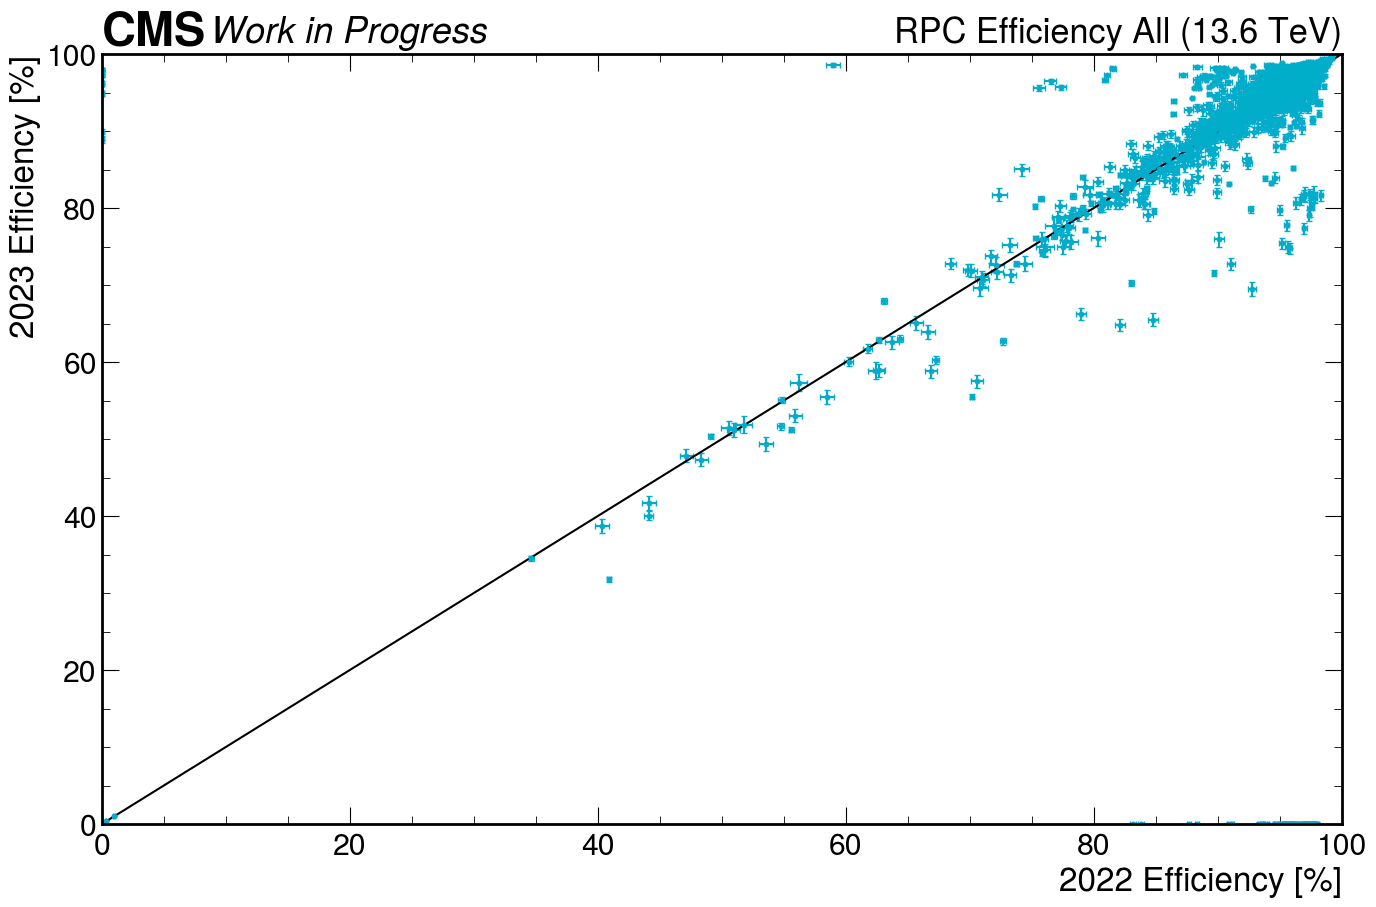

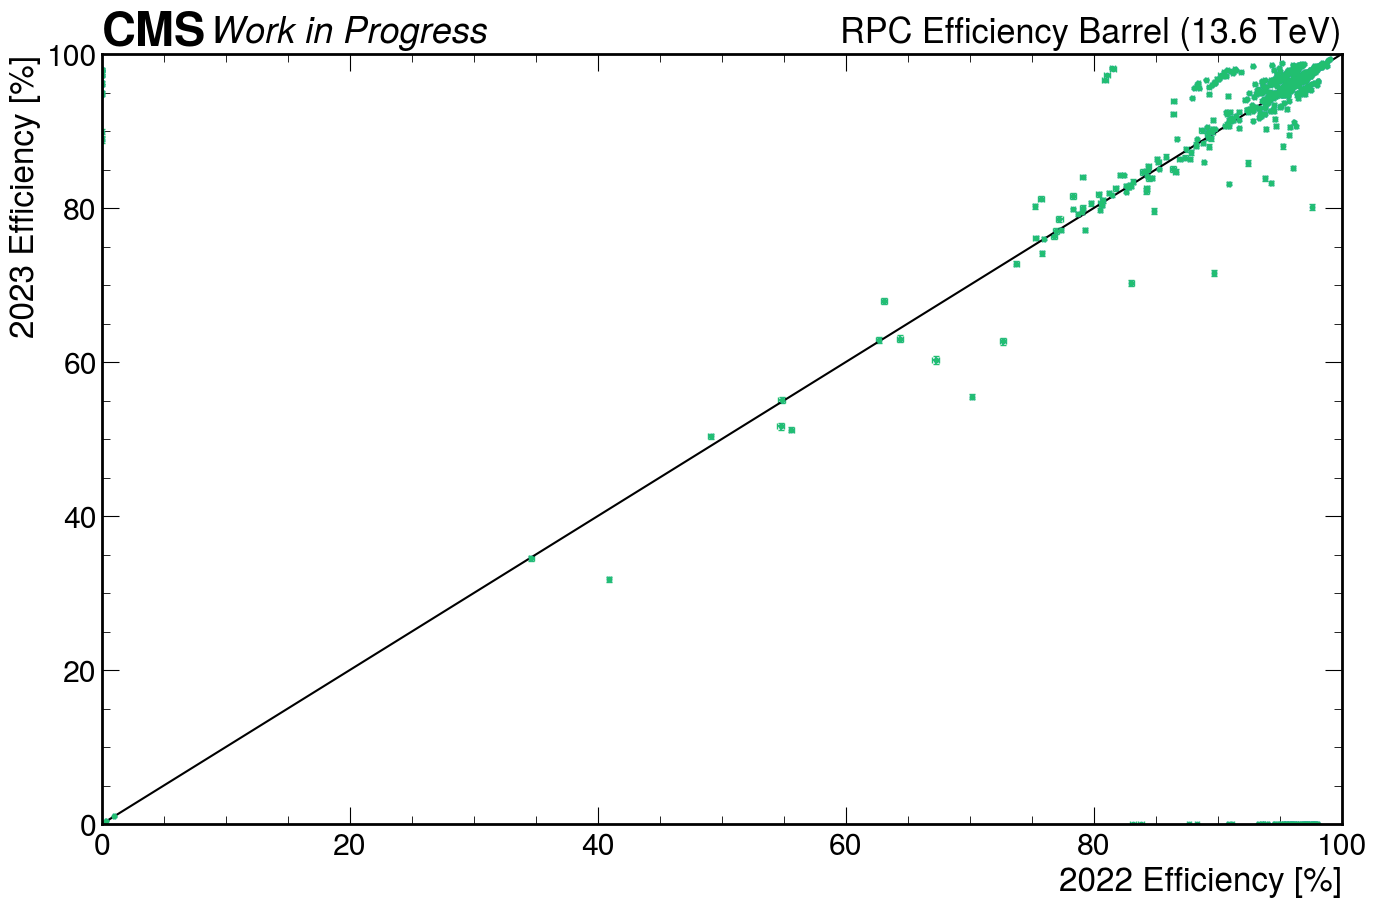

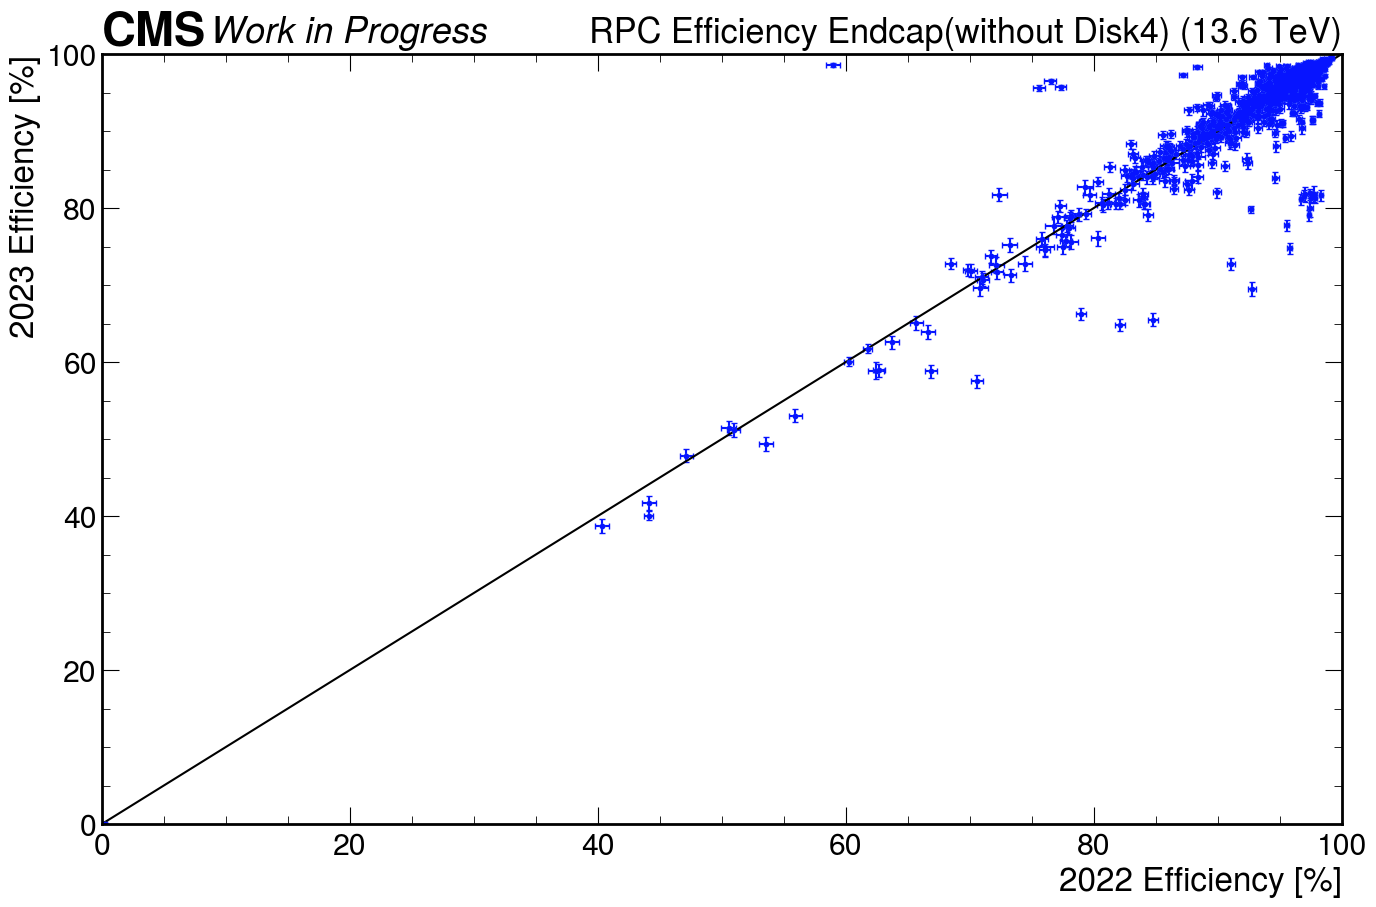

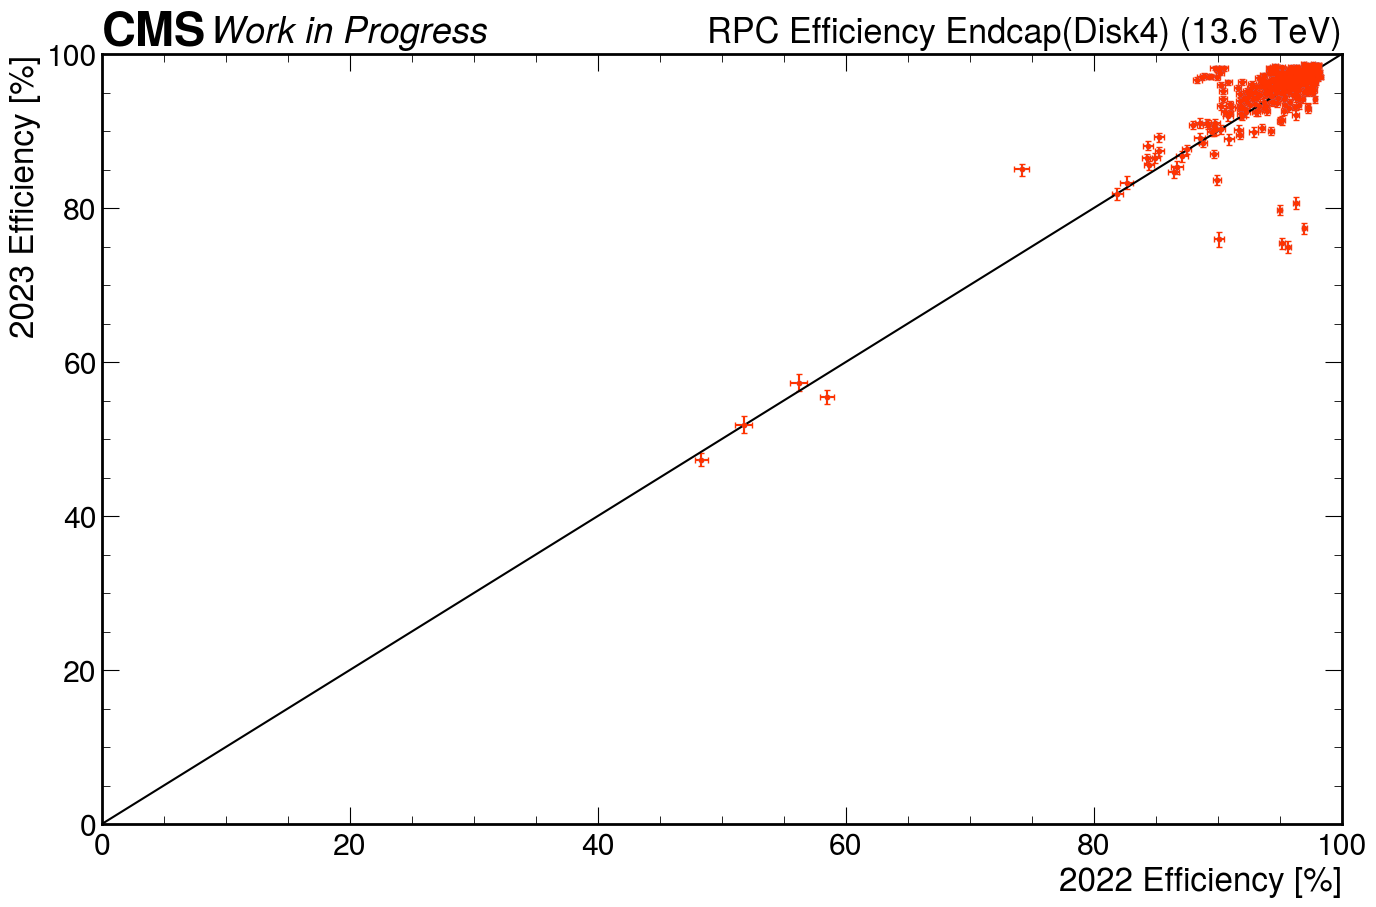

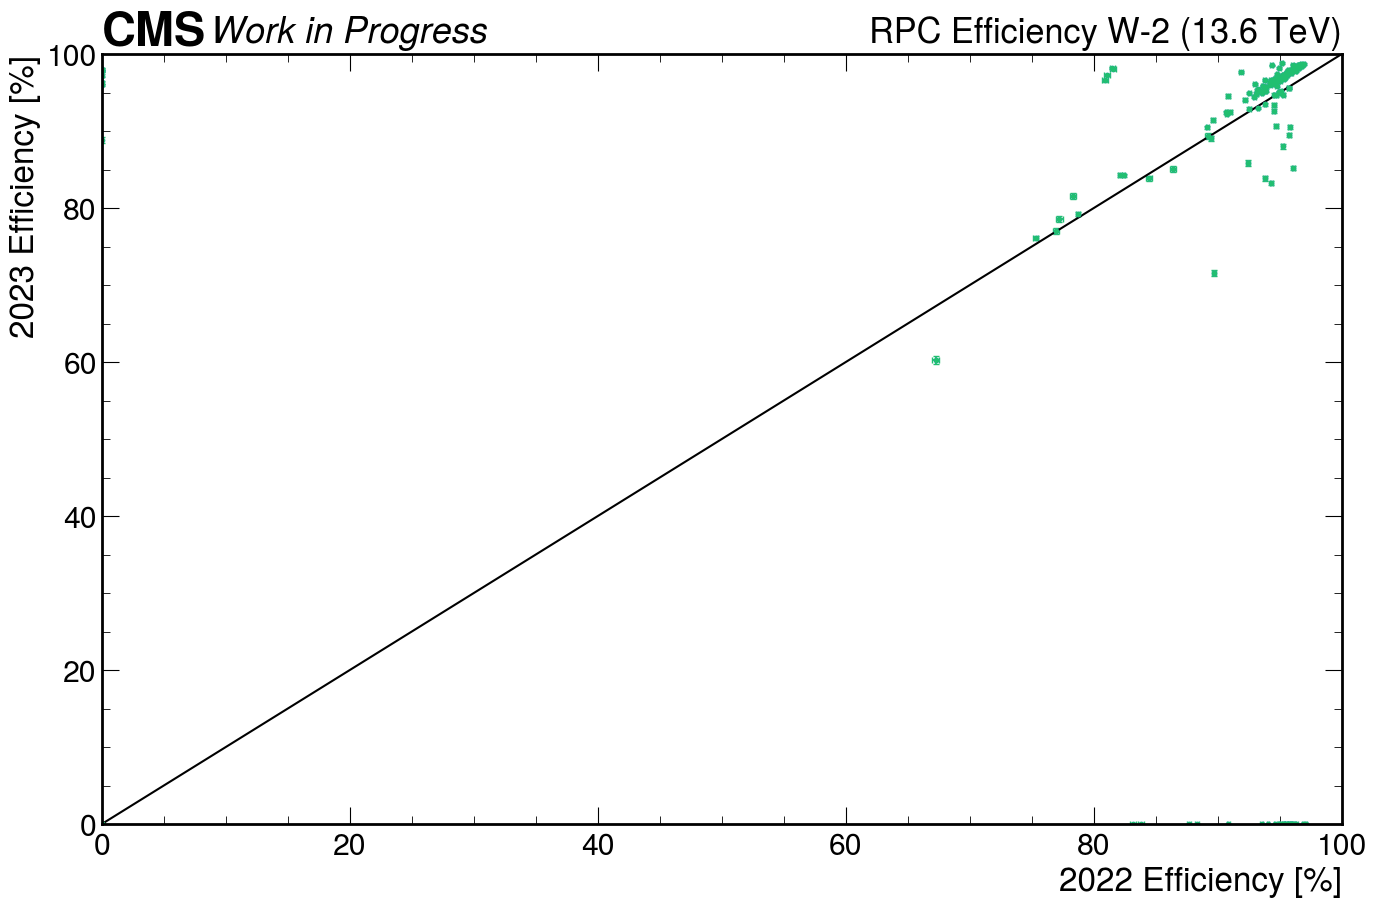

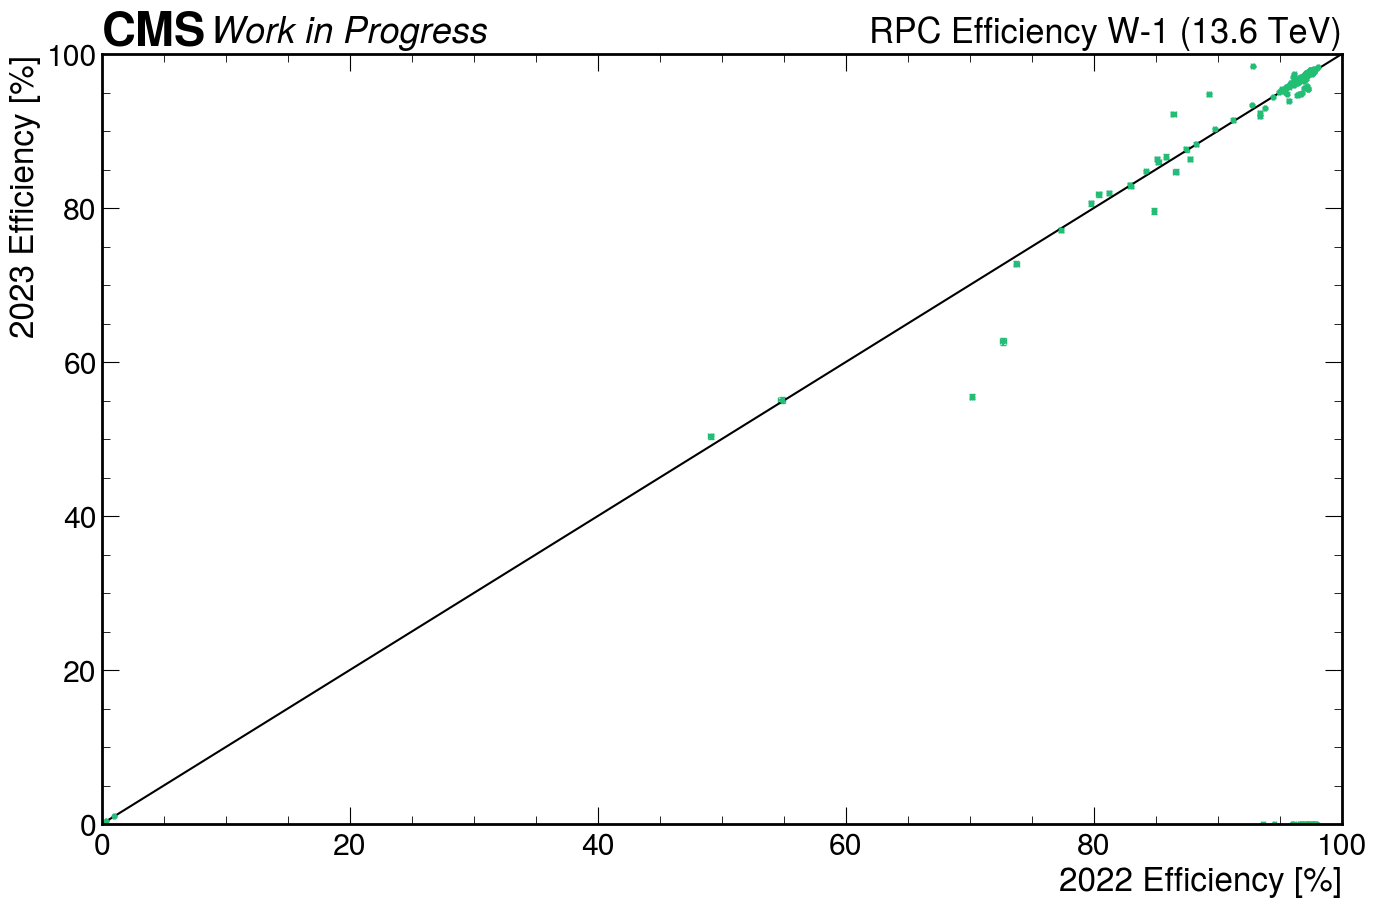

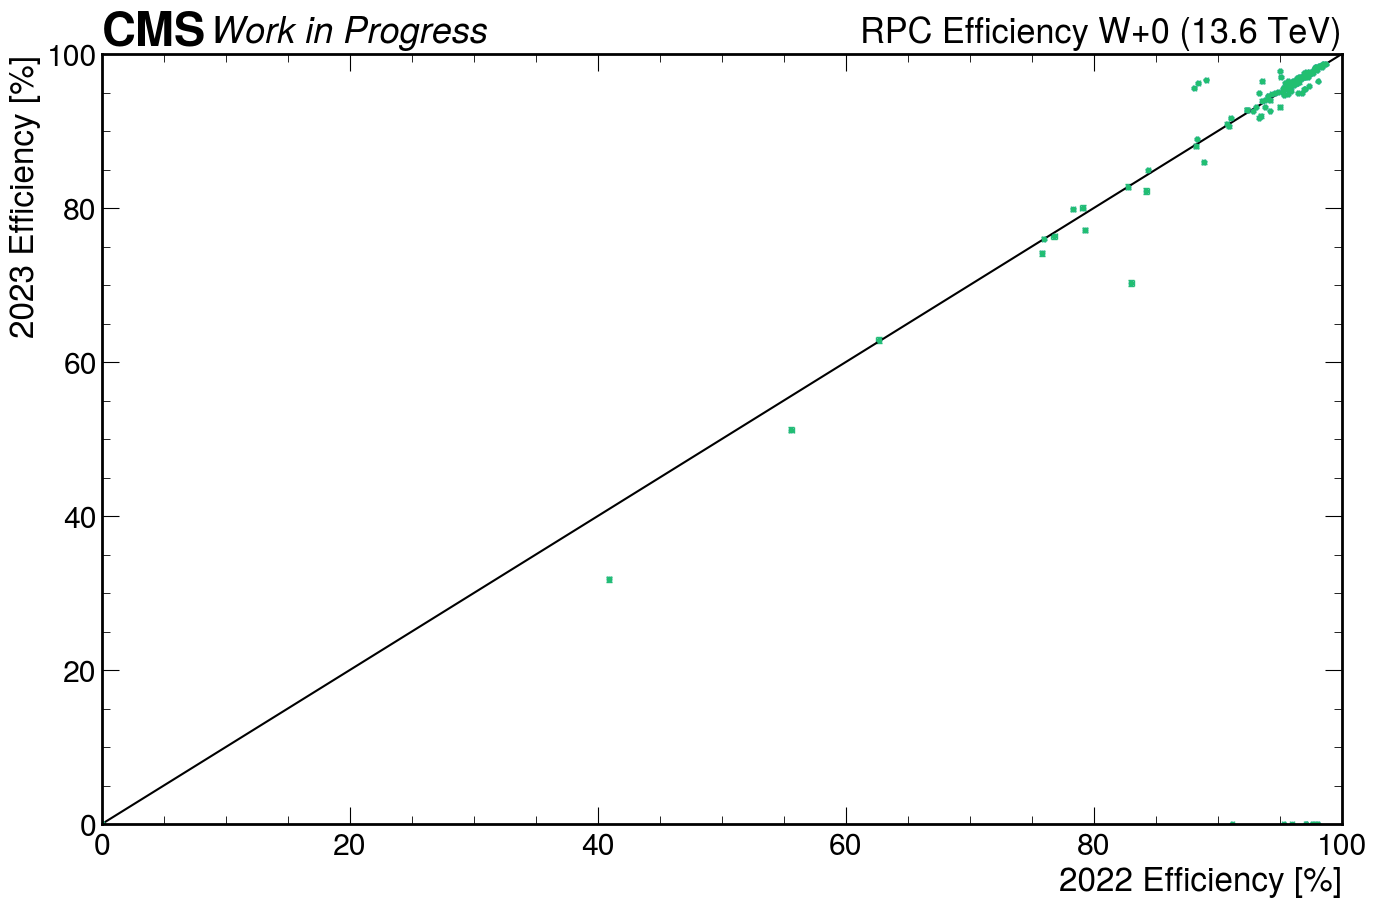

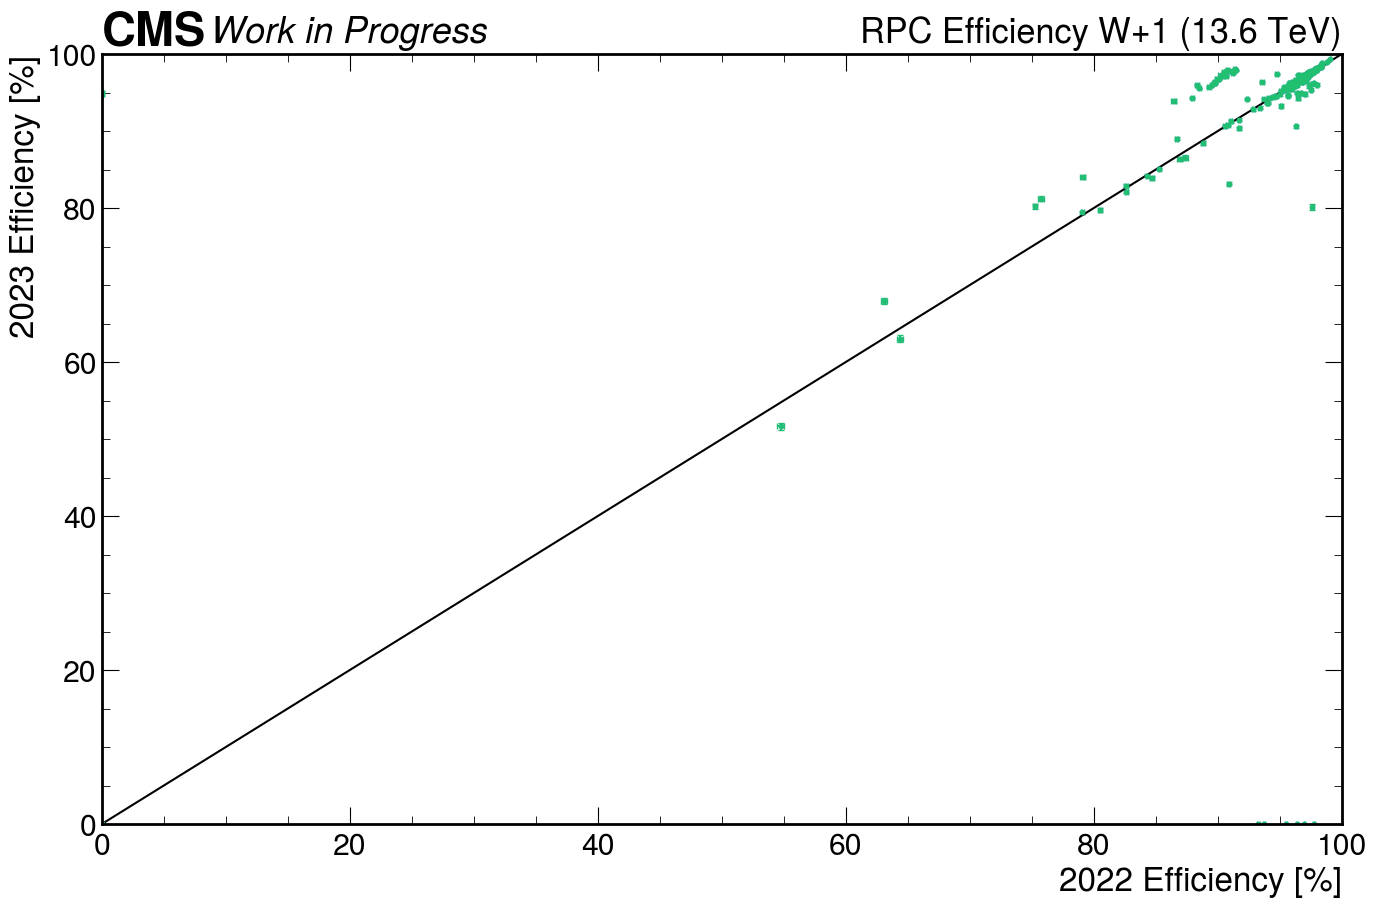

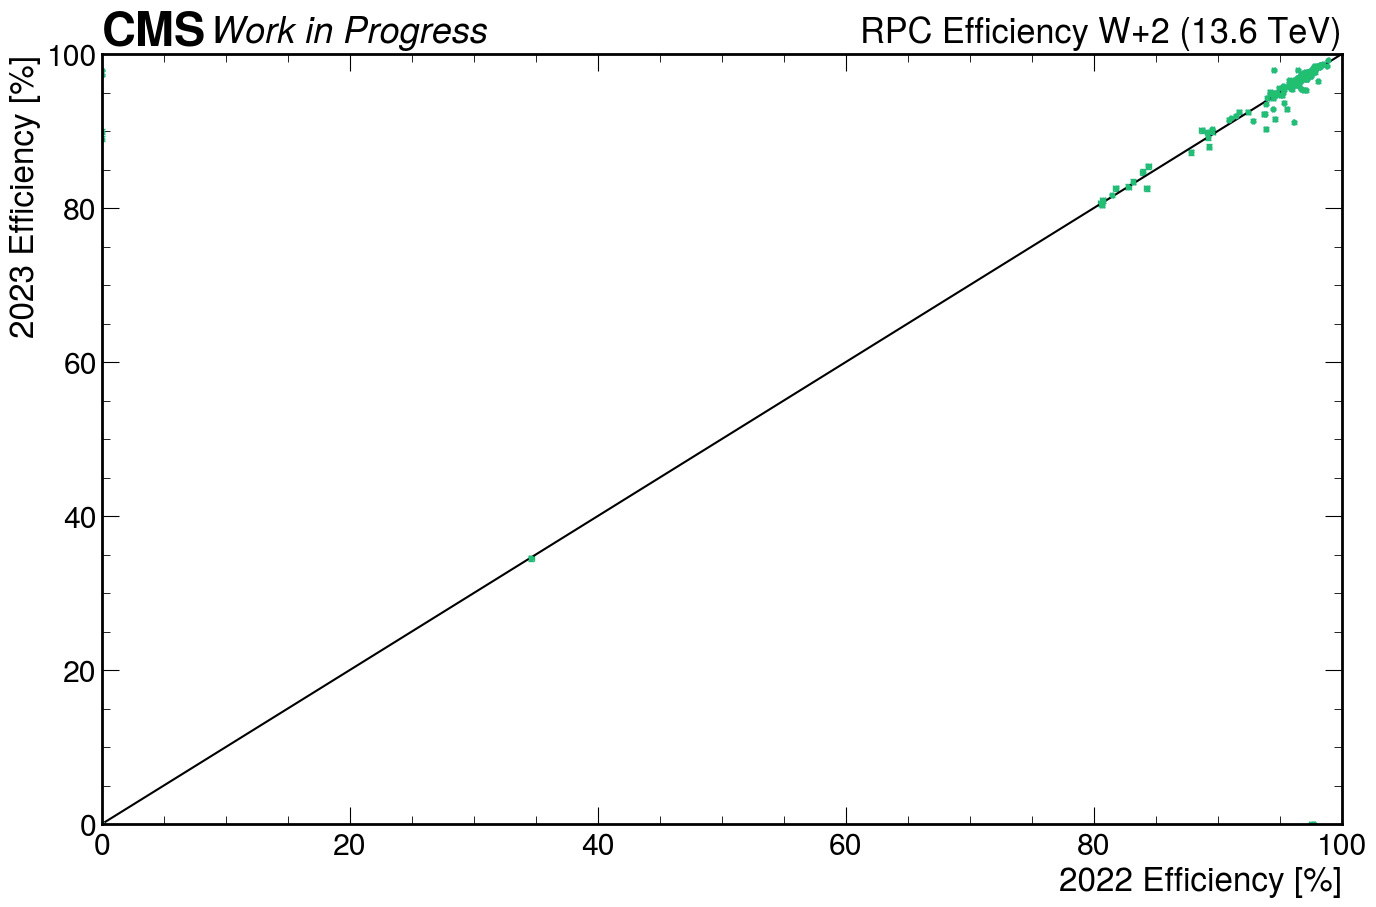

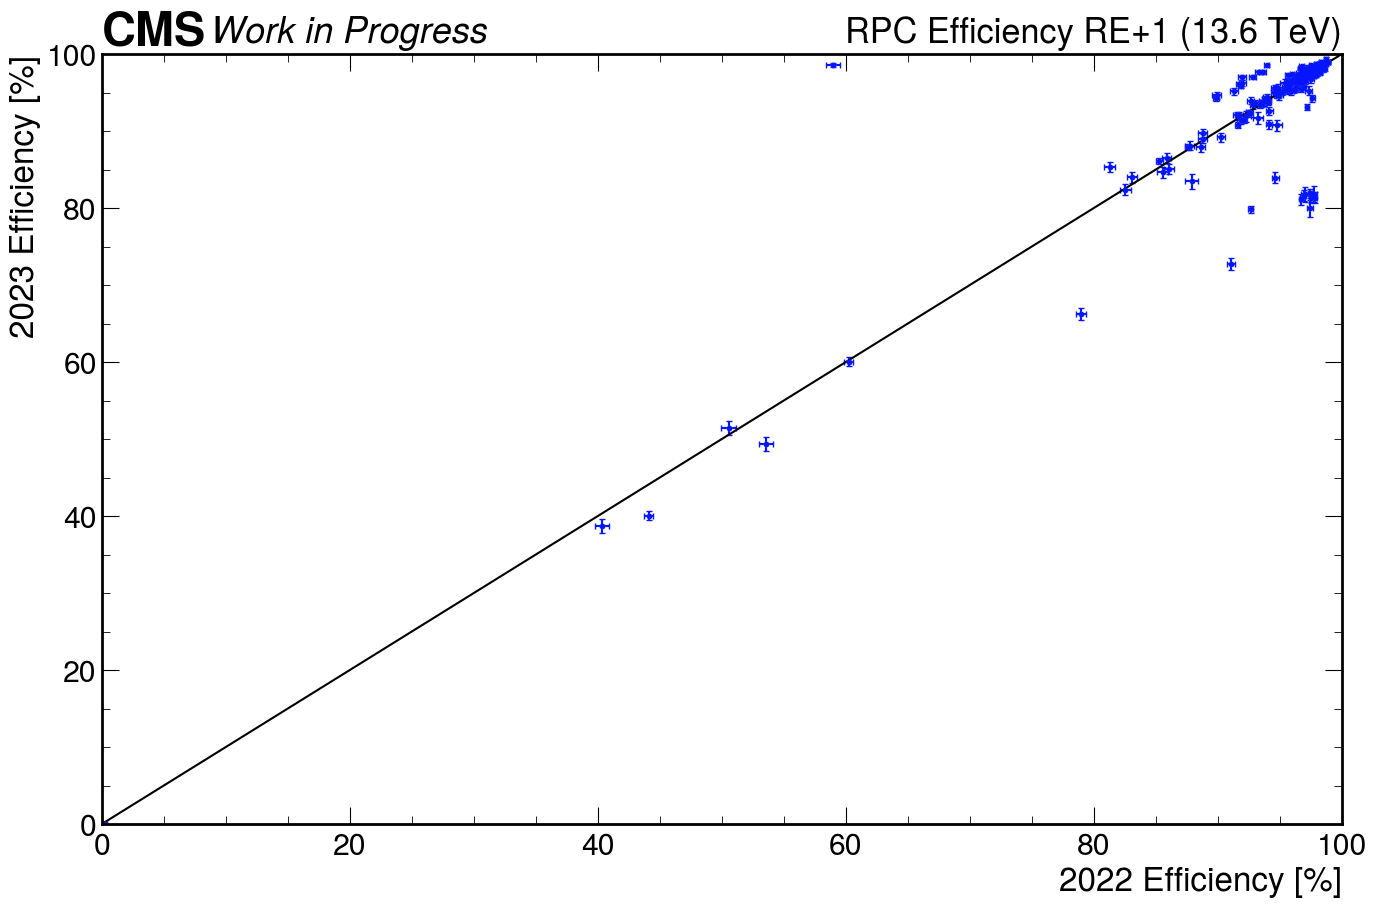

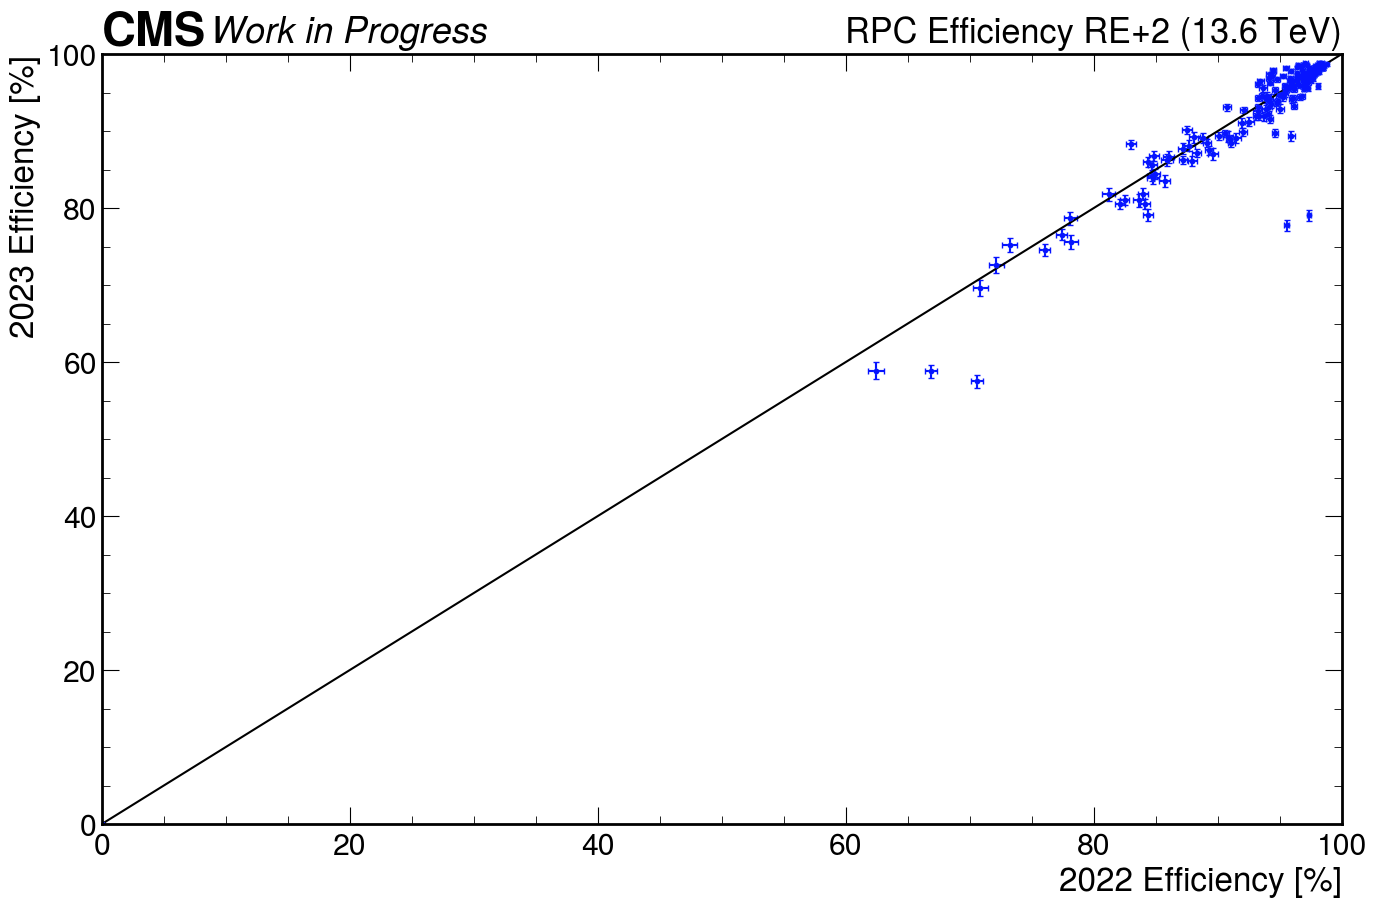

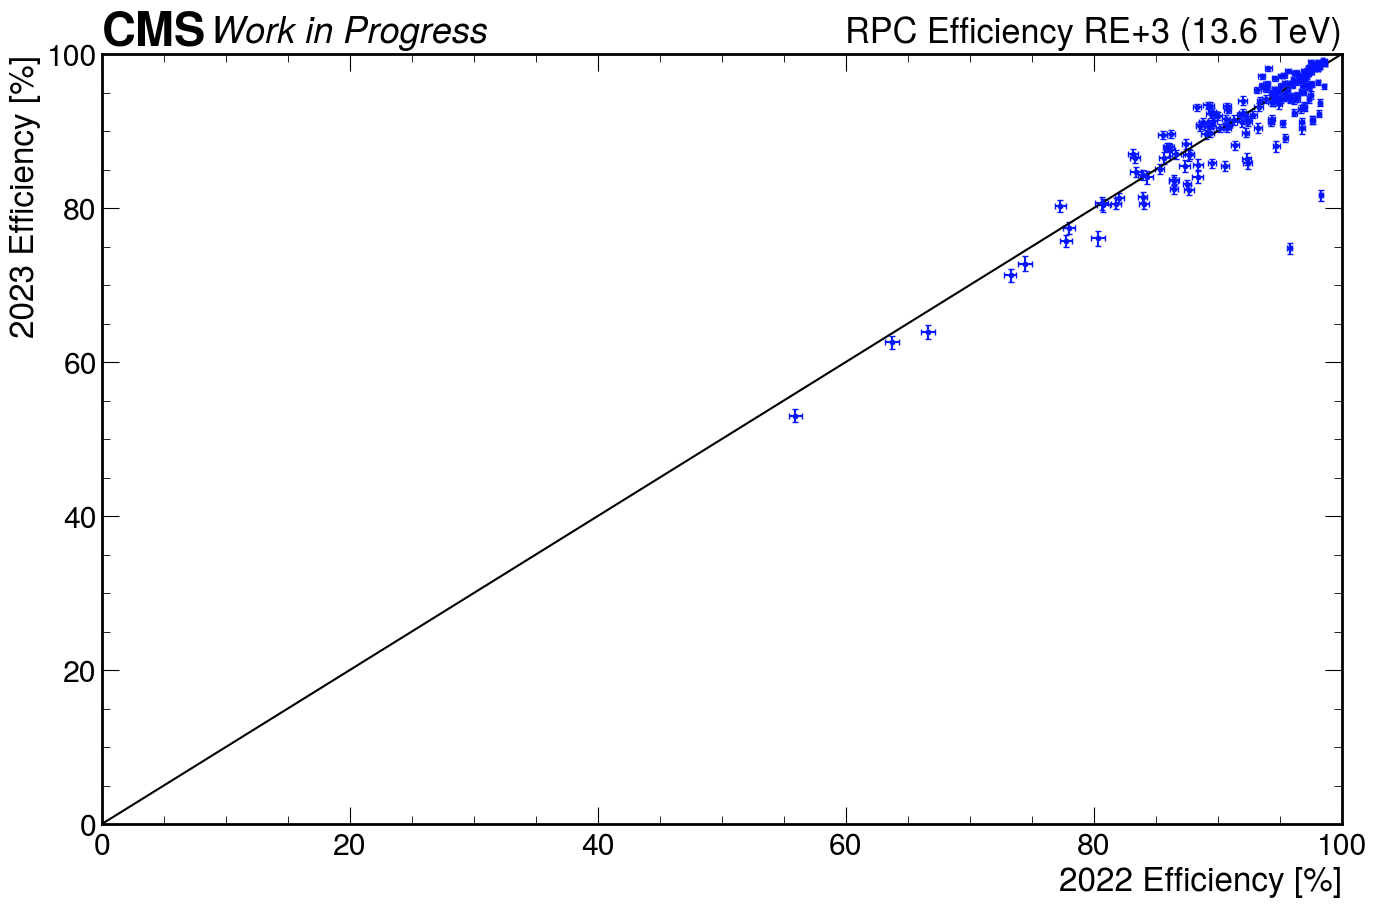

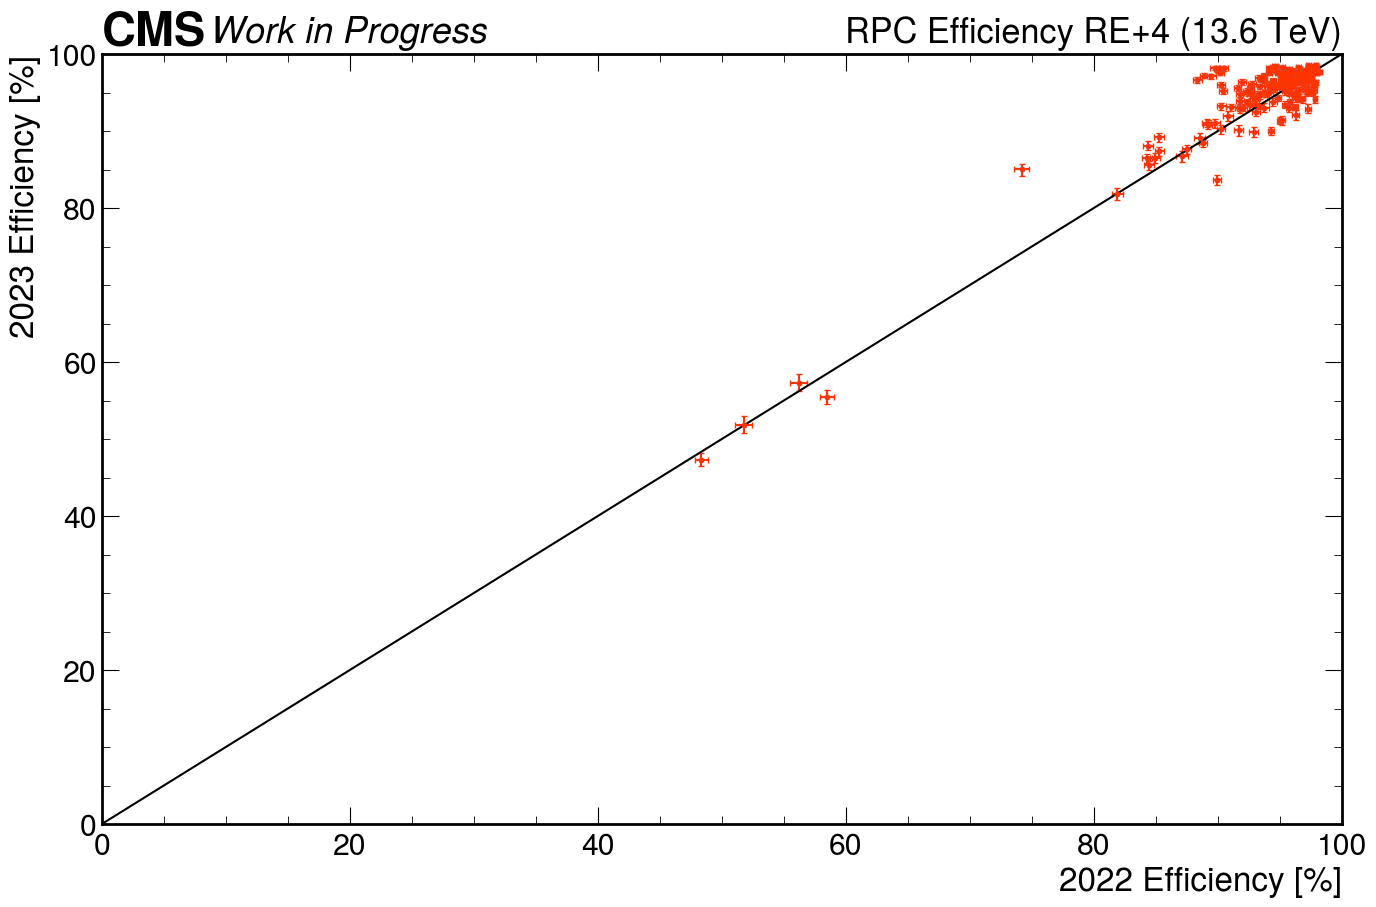

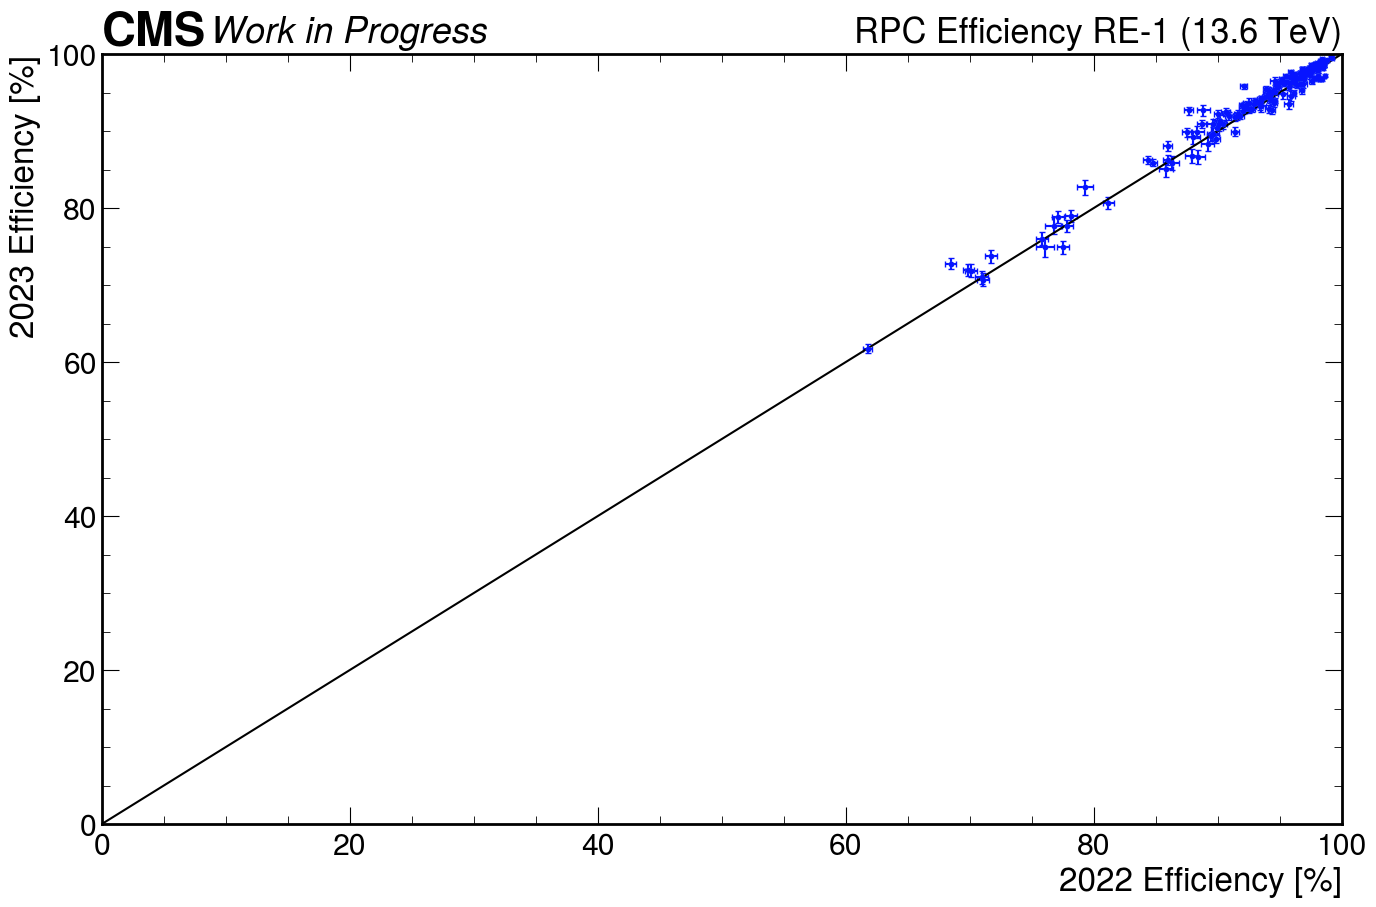

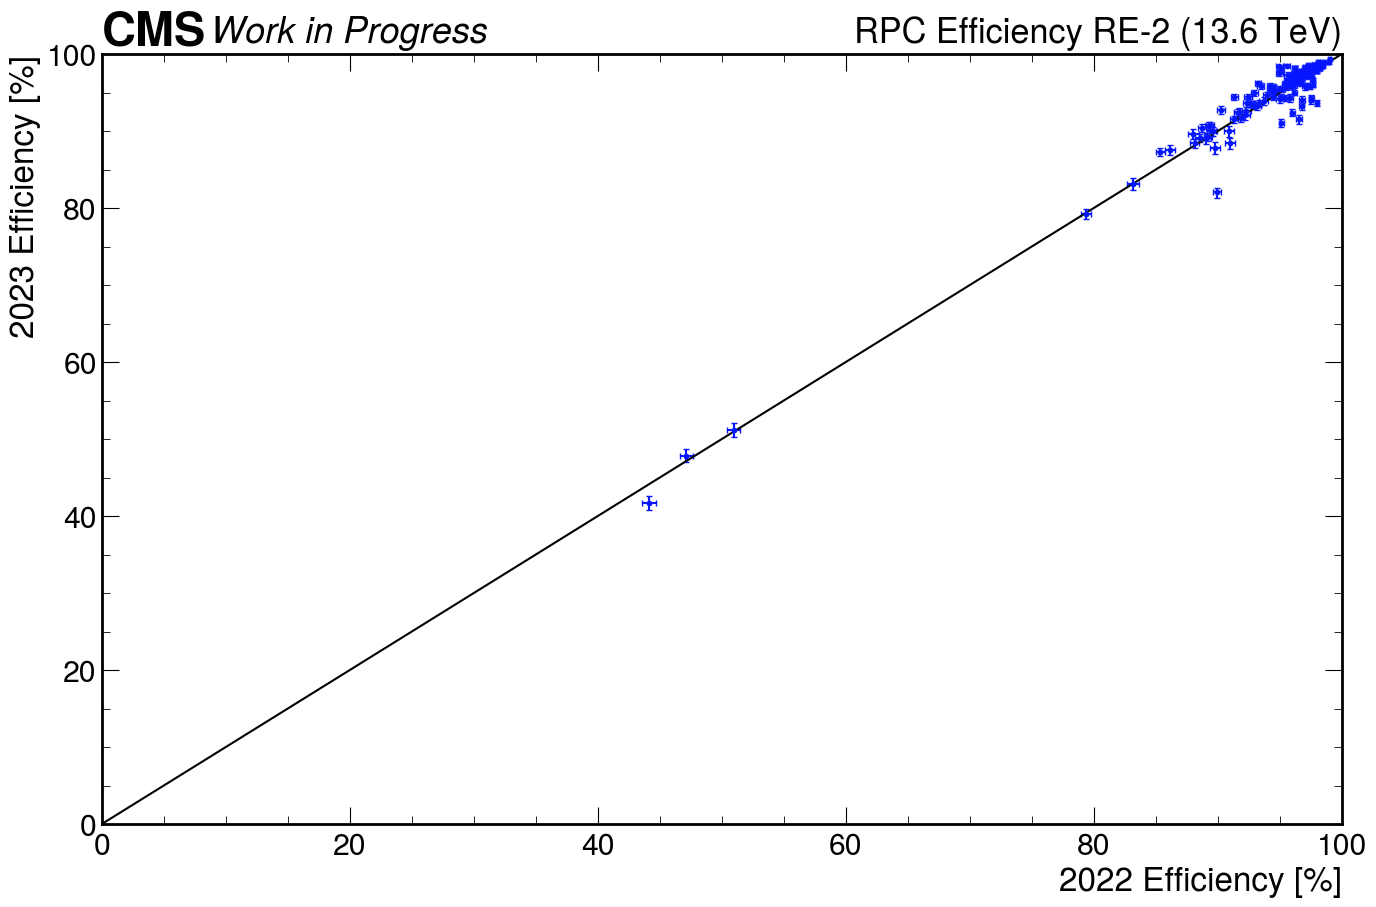

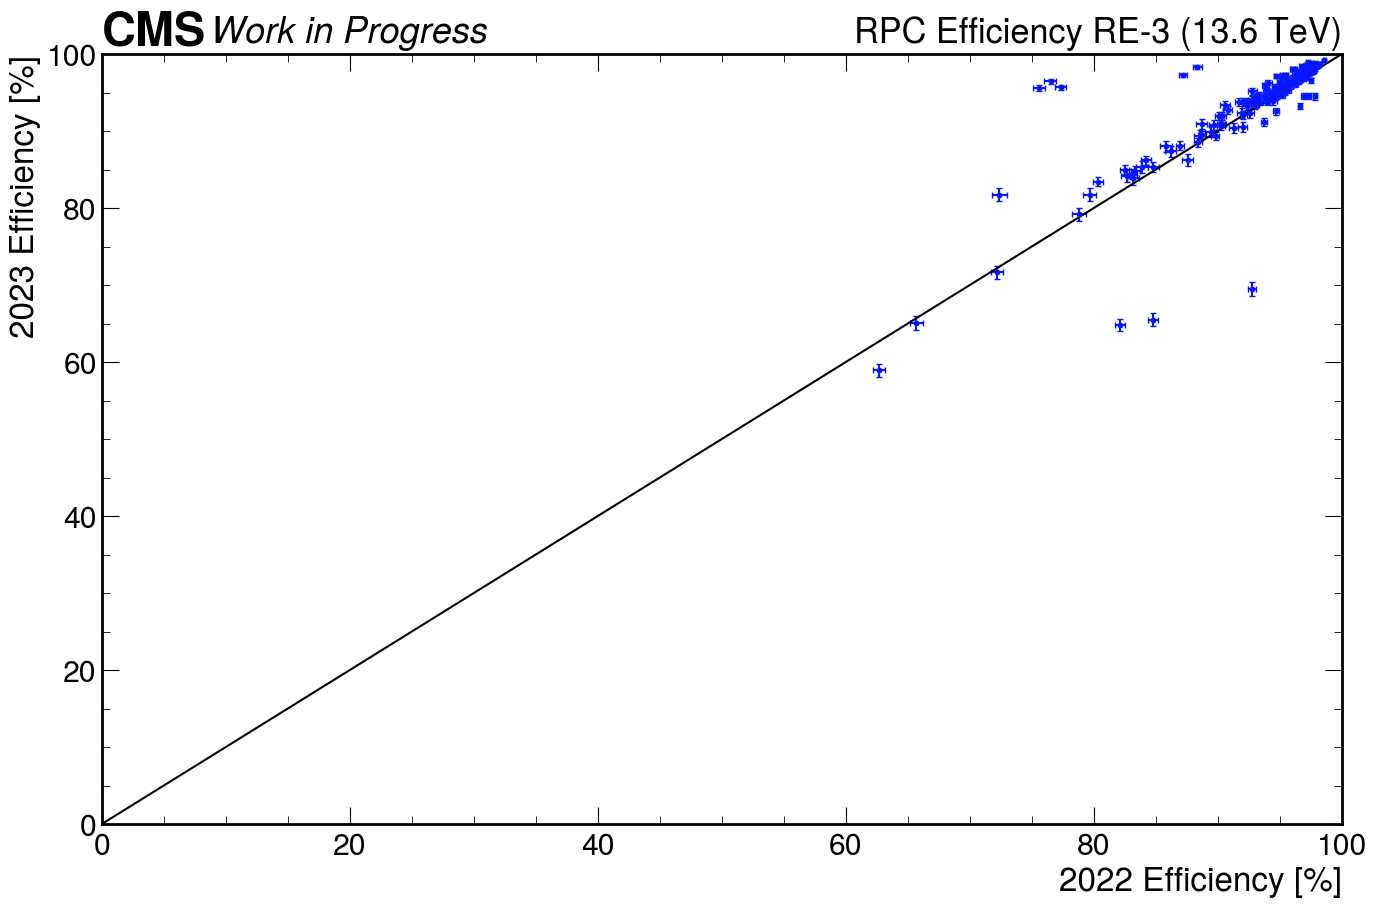

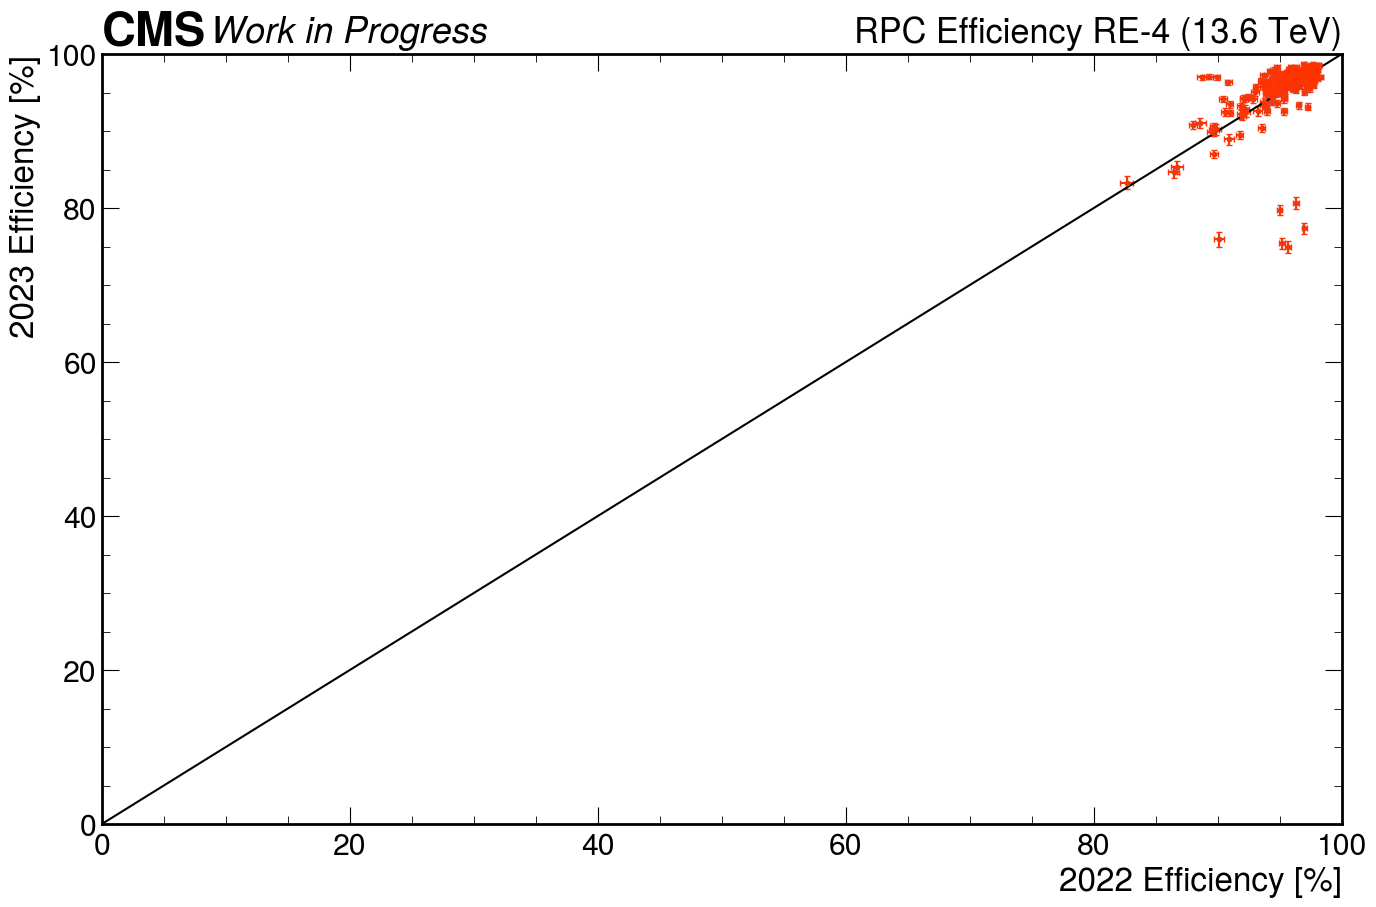

In [63]:
working_dir = Path('/users/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/TnP_Plotting')
data_2022_path = working_dir / 'data' / 'Run2022.root'
data_2023_path = working_dir / 'data' / 'Run2023.root' 
geom_path = working_dir / 'geometry' / 'run3.csv'
roll_blacklist_path = working_dir / 'blacklist' / 'roll-blacklist.json'
output_dir = working_dir / 'plotting' / 'EffDetScatter2D'


data_2022 = uproot.open(data_2022_path)
data_2023 = uproot.open(data_2023_path)

geom = pd.read_csv(geom_path)

if roll_blacklist_path is None:
    roll_blacklist = set()
else:
    with open(roll_blacklist_path) as stream:
        roll_blacklist = set(json.load(stream))

regions = [
    'all', 'barrel', 'disk123', 'disk4',
    'W-2', 'W-1', 'W+0', 'W+1', 'W+2',
    'RE+1', 'RE+2', 'RE+3', 'RE+4',
    'RE-1', 'RE-2', 'RE-3', 'RE-4',
]

region_labels = [
    'All', 'Barrel', 'Endcap(without Disk4)', 'Endcap(Disk4)',
    'W-2', 'W-1', 'W+0', 'W+1', 'W+2',
    'RE+1', 'RE+2', 'RE+3', 'RE+4',
    'RE-1', 'RE-2', 'RE-3', 'RE-4',
]

errorbarcolors = [
    ("#8EFFF9", "#00AEC9"), ("#d3f5e4", "#21bf70"), ("#7CA1FF", "#0714FF"), ("#FF6666", "#FF3300"),
    ("#d3f5e4", "#21bf70"), ("#d3f5e4", "#21bf70"), ("#d3f5e4", "#21bf70"), ("#d3f5e4", "#21bf70"), ("#d3f5e4", "#21bf70"),
    ("#7CA1FF", "#0714FF"), ("#7CA1FF", "#0714FF"), ("#7CA1FF", "#0714FF"), ("#FF6666", "#FF3300"),
    ("#7CA1FF", "#0714FF"), ("#7CA1FF", "#0714FF"), ("#7CA1FF", "#0714FF"), ("#FF6666", "#FF3300"),
]

for idx in range(len(regions)):
    mh.style.use(mh.styles.CMS)
    fig, ax = plt.subplots(figsize=(16, 10))
    label = "Work in Progress"
    com = 13.6
    mh.cms.label(ax=ax, data=True, label=label, com=com, year=f"RPC Efficiency {region_labels[idx]}", fontsize=26)
    ax.set_xlabel('2022 Efficiency [%]', fontsize=24)
    ax.set_ylabel('2023 Efficiency [%]', fontsize=24)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    plot_eff_scatter_2d(
        data1 = data_2022,
        data2 = data_2023,
        geom = geom,
        roll_blacklist = roll_blacklist,
        region = regions[idx],
        ax = ax,
        errorbarcolor = errorbarcolors[idx][1]
    )
    ax.plot(np.linspace(-20, 120, 140), np.linspace(-20, 120, 140), c='black')

    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    fig.savefig(output_dir / f"{regions[idx]}.png")
